
   
# Casus: Karakteristiek bepalen
*Auteur: S.A. Klop*
    
In deze casus wordt behandelt hoe tijdreeksanalyse (TRA) kan worden gebruikt voor het bepalen van de GXG waarden van een grondwaterstand meetreeks. 

**Inhoudsopgave**

- [Deel I: Inschatten GXG voor korte reeks](#Deel-I:-Inschatten-GXG-voor-korte-reeks)
    - [Beschikbare gegevens](#Beschikbare-gegevens)
    - [Opstellen tijdreeksmodel](#Opstellen-van-het-tijdreeksmodel)
    - [Bepalen GLG en GHG](#Bepalen-GLG-en-GHG)
    
- [Deel II: Invullen missend deel van meetreeks](#Deel-II:-Invloed-waterloop)
    - [Beschikbare data](#Beschikbare-data)
    - [Opzetten model](#Opzetten-tijdreeksmodel)

In [1]:
# inladen van de benodigde python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.stats import norm

import pastas as ps

%matplotlib inline
ps.set_log_level("ERROR")

## Deel I: Inschatten GXG voor korte reeks

Het waterschap heeft de grondwaterstand in Peilbuis A gemeten vanaf 1 augustus 2008 tot 28 juli 2015, een totale periode van 7 jaar. Dit is de enige peilbuis in het gebied. Het Waterschap wil graag een inschatting maken van de Gemiddelde Laagste Grondwaterstand (GLG) en Gemiddelde Hoogste Grondwaterstand (GHG) binnen het gebied. 

Voor de GLG worden jaarlijks de 3 laagste grondwaterstanden gemiddeld over de periode van 1 april tot en met 31 maart, over een periode van minstens 8 jaar wordt deze jaarlijkse waarde gemiddeld om de GLG te bepalen. Voor de GHG worden de 3 hoogste waarden per hydrologisch jaar gebruikt. De stijghoogte is in peilbuis A te kort gemeten voordeze berekening (<8 jaar). Met behulp van tijdreeksanalyse kan worden geprobeerd om toch een inschatting te maken van de GHG en GLG in het gebied, door de grondwaterstand terug in de tijd de extrapoleren.


### Beschikbare gegevens
De gemeten grondwaterstand is te zien in de onderstaande afbeelding. De gemeten grondwaterstand varieert tussen de 27.2 en 28.7 m NAP. 

Text(0.5, 1.0, 'Gemeten grondwaterstand in Peilbuis A')

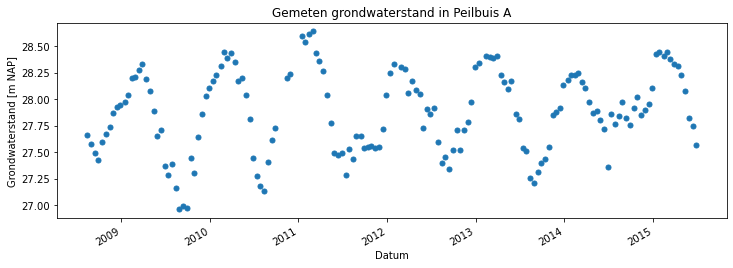

In [2]:
gws = pd.read_csv("data/head.csv",
                   index_col=0, parse_dates=True)

datum = '2008-08-01'

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws[datum:].plot(ax=ax, color='C0', ls='', marker='.', markersize=10, legend=False)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis A')

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van Peilbuis A. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. Te zien is dat deze meetreeksen teruggaan tot 1980, en dus langer zijn dan de gemeten grondwaterreeksen. 

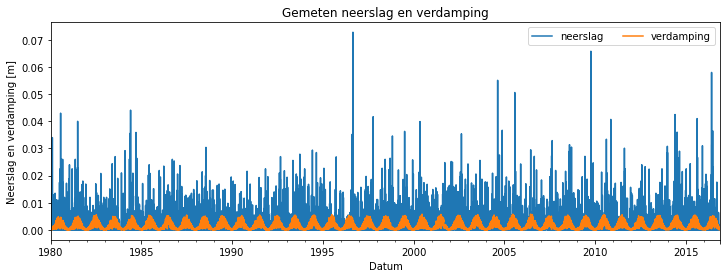

In [3]:
neerslag =  pd.read_csv("data/rain.csv",
                    index_col=0, parse_dates=True)
verdamping =  pd.read_csv("data/evap.csv",
                    index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend(['neerslag', 'verdamping'], ncol=2);

### Opstellen van het tijdreeksmodel

Er wordt een model opgesteld om de grondwaterstand te simuleren. Hiervoor wordt de volledige tijdreeks gebruikt. In de tijdreeks zijn geen uitbijters gevonden. Er is daarom geen reden om de meetreeks voor te bewerken voordat deze kan worden gemodelleerd.

De neerslag en potentiele verdamping worden gebruikt als verklarende reeksen. Voor de verklarende reeksen wordt een respons gekozen. De responsfunctie beschrijft de reactie van het grondwater op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type responsfunctie kiest en waarbij de parameters van deze functie worden geoptimaliseerd. Hier wordt gekozen voor de Gamma responsfunctie voor de neerslag en verdamping.

In het tijdreeksmodel wordt gekozen om dezelfde responsefunctie te gebruiken voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule $ R = P - f \cdot E$, waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door gekalibreerd. Naast de verklarende reeksen wordt ook een constante gefit. Na het kiezen van de modelstructuur kan het tijdreeksmodel worden geoptimaliseerd. 

In [4]:
# opzetten model
ml = ps.Model(gws[datum:])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve(report=False)

# simuleren van de grondwaterstand
gws_simulatie1 = ml.simulate()

Het tijdreeksmodel heeft een R$^2$ van 0.93. In de onderstaande afbeelding is het resultaat van de simulatie van de grondwaterstand door het tijdreeksmodel weergeven. De bijdrages van de neerslag en verdamping zijn apart weergeven. Voor de verdamping is duidelijk het seizoensgebonden effect te zien, in de zomerperiode wordt de negatieve bijdrage van de verdamping groter. 

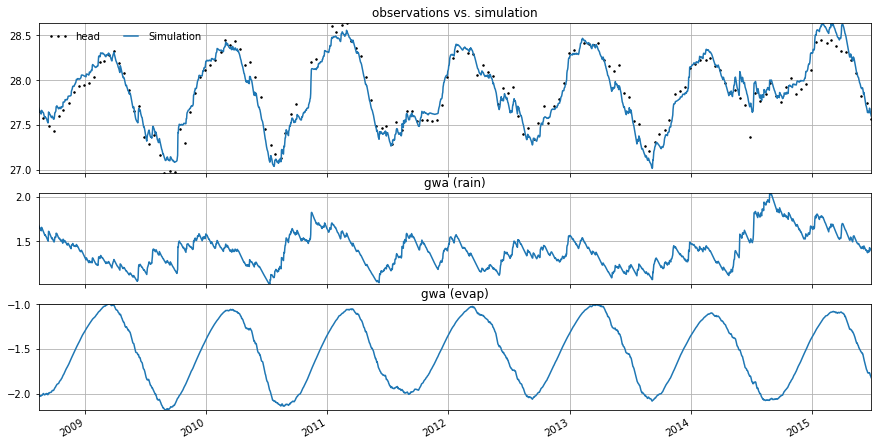

In [5]:
ml.plots.decomposition(figsize=(12,6));

### Bepalen GLG en GHG

De meetreeks is te kort om de GXG op basis van de gemeten waarden te bepalen. Met behulp van het tijdreeksmodel kan de grondwaterstand voor een langere periode worden gesimuleerd. De grondwaterstand kan worden gesimuleerd tot aan de start van de neerslag en verdampingsmeetreeksen. Hierbij wordt de aanname gedaan dat het hydrologische systeem in deze periode niet is verandert en dat de gevonden relatie (of respons) gelijk is gebleven.

In de onderstaande afbeelding is de gesimuleerde reeks te zien vanaf 1980 (het moment waarop de neerslag en verdampingsmeetreeksen starten). Op basis hiervan kunnen de GLG en GHG worden afgeleid. De beperking hiervan is dat er op die manier geen enkele rekening wordt gehouden met de modelonzekerheid.

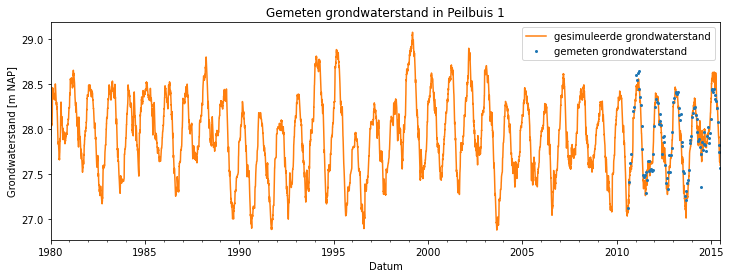

In [6]:
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ml.simulate(tmin=1980).plot(ax=ax, color='C1')
gws['2010-08-01':].plot(ax=ax, color='C0', ls='', marker='o', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend(['gesimuleerde grondwaterstand',f'gemeten grondwaterstand']);
ax.set_xlim(xmin='1980');

Om de onzekerheden van de GLG en GHG te bepalen is het nodig iets te zeggen over de onzekerheid van het tijdreeksmodel, uitgedrukt in de standaarddeviatie van de modelparameters. Om dit te doen moet worden gecontroleerd of de resultaten van het tijdreeksmodel voldoende zijn om de onzekerheid van de parameters goed in te kunnen schatten. 

Bij het bepalen van de onzekerheid van de modelparameters is de aanname dat de ruis van het model zogenaamde "witte ruis" is. Hiervoor worden vier aannames gecontroleerd:

- het gemiddelde van de ruis is nul;
- de waardes zijn onafhankelijk van elkaar;
- De ruis is normaal verdeeld;
- De ruis heeft een constante variantie.

Als de ruis aan deze toetsen voldoet mag aangenomen worden dat de ruis "witte ruis" betreft en dat de standaard deviatie van de modelparameters juist is ingeschat.


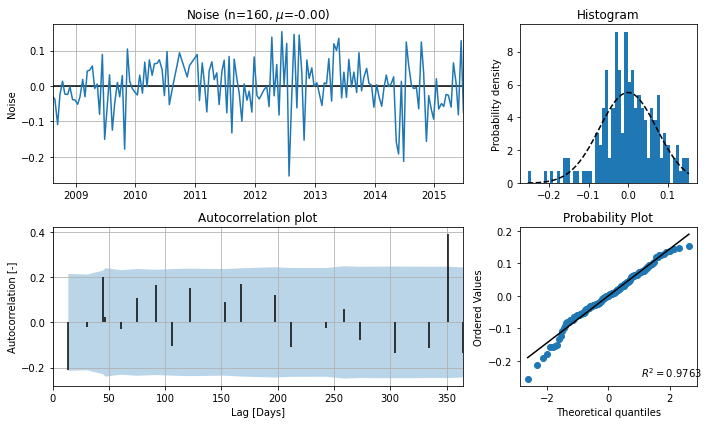

In [7]:
ml.plots.diagnostics(acf_options=dict(min_obs=50));

In de figuur linksboven is de ruis weergeven. Te zien is dat er geen duidelijke trend zichtbaar is en dat de gemiddelde waarde ($\mu$) gelijk is aan 0,00. In de figuur linksonder is de autocorrelatie van de lag weergeven met het bijbehorende 95% zekerheidsinterval. Hiervoor geldt dat 95% vaan de autocorrelatie waardes binnen dit interval moeten liggen. Er lijkt geen sprake te zijn van een duidelijk autocorrelatie. De figuur rechtsboven weergeeft de ruis als verdeling, met een bijbehorende normale verdeling, gefit op de ruis. Deze figuur kan worden gebruikt om te kijken of de ruis aan een normale verdeling voldoet. De figuur rechtsonder kan ook worden gebruikt om de normaliteit te toetsen. De ruis lijkt voor deze reeks redelijk normaal verdeelt te zijn. Op basis van deze analyse van de ruis wordt aangenomen dat de standaard fouten van de parameters juist zijn ingeschat. 

Om rekening te houden met de onzekerheid van de modelparameters bij het bepalen van de GXG worden de volgende stappen doorlopen:

1. Met behulp van de covariantie matrix van het geoptimaliseerde model worden willekeurig 1000 verschillende parameters sets getrokken uit een multivariate normaal verdeling.
2. Met elk van deze 1000 parameter sets wordt de grondwaterstand gesimuleerd vanaf 2007, deze reeksen zijn te zien in de onderstaande afbeelding. 
3. Voor elk van deze gesimuleerde reeksen wordt vervolgens de GHG en GLG bepaald.

Het resultaat is niet een deterministische GXG, maar een GXG met een bandbreedte die de onzekerheid van de modelparameters in acht neemt. 

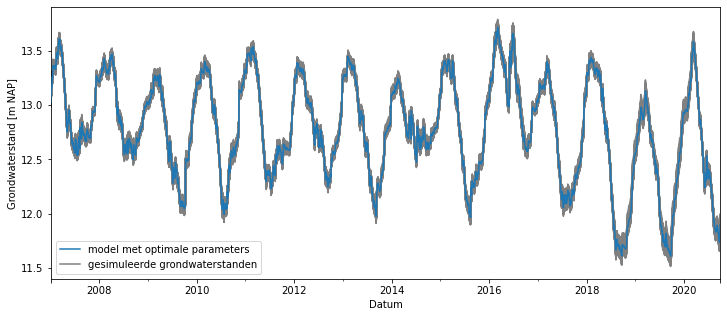

In [16]:
# Get 1000 parameters for monte carlo analysis
parameter_samples = ml.fit._get_parameter_sample(n=1000)

fig,ax = plt.subplots(figsize=(12,5))
ml.simulate(tmin='2007').plot(zorder=10)

glg = []
ghg = []

for p in parameter_samples:
    s = ml.simulate(p=p, tmin='2007')
    ax.plot(s, color='gray')
    ghg.append(ps.stats.ghg(s))
    glg.append(ps.stats.glg(s))

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.legend(["model met optimale parameters", 'gesimuleerde grondwaterstanden'], loc=3);

In de onderstaande figuren zijn de berekende GHG en GLG waardes te zien. Over deze waardes is een normale verdeling gefit waarbij het gemiddelde en de standaarddeviatie zijn bepaald. In de figuur is met een blauwe lijn de GHG of GLG aangegeven welke horen bij het geoptimalisserde tijdreeksmodel. 

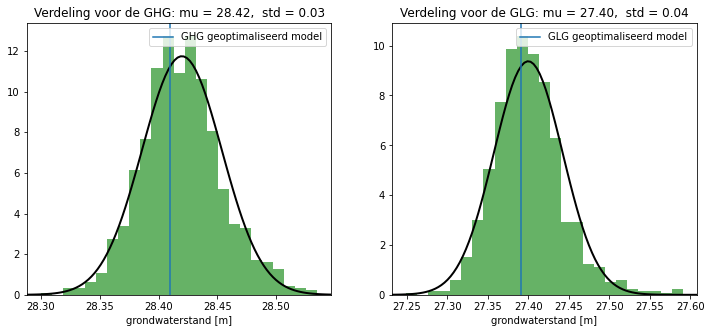

In [9]:
# GXG bepalen voor de verschillende reeksen
df = pd.DataFrame()
df.loc['tijdreeksmodel vanaf 2007','GLG'] = ps.stats.glg(ml.simulate(tmin='2007'), min_n_years=8)
df.loc['tijdreeksmodel vanaf 2007','GHG'] = ps.stats.ghg(ml.simulate(tmin='2007'), min_n_years=8)

# Plot the histogram.
fig, ax = plt.subplots(1,2, figsize=(12,5))

# Fit een normale verdeling op de GHG:
mu, std = norm.fit(ghg)
ax[0].hist(ghg, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = ax[0].set_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0].plot(x, p, 'k', linewidth=2)
title = "Verdeling voor de GHG: mu = %.2f,  std = %.2f" % (mu, std)
ax[0].set_title(title);
ax[0].axvline(ps.stats.ghg(ml.simulate(tmin='2007'), min_n_years=8), label='GHG geoptimaliseerd model')
ax[0].legend()
ax[0].set_xlabel('grondwaterstand [m]')
# Fit een normale verdeling op de GLG:
mu, std = norm.fit(glg)
ax[1].hist(glg, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = ax[1].set_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[1].plot(x, p, 'k', linewidth=2)
title = "Verdeling voor de GLG: mu = %.2f,  std = %.2f" % (mu, std)
ax[1].set_title(title);
ax[1].axvline(ps.stats.glg(ml.simulate(tmin='2007'), min_n_years=8), label='GLG geoptimaliseerd model');
ax[1].legend()
ax[1].set_xlabel('grondwaterstand [m]');

Na het uitvoeren van de analyse is toch de oudere meetreeks van Peilbuis A teruggevonden, deze meetreeks start in 1985. Het waterschap besluit om de eerdere analyse de controleren met de nieuw gevonden data. Voor de periode vanaf 2007 zijn de GXG waarden bepaald, deze zijn weergeven in de onderstaande tabel.

De GXG op basis van de nieuwe metingen vallen binnen de bandbreedte die uit bepaald is in de vorige analyse. 

In [10]:
df.loc['controle nieuwe metingen','GLG'] = ps.stats.glg(gws['head']['2007':])
df.loc['controle nieuwe metingen','GHG'] = ps.stats.ghg(gws['head']['2007':])

display(df.round(2))

,GLG,GHG
tijdreeksmodel vanaf 2007,27.39,28.41
controle nieuwe metingen,27.37,28.41


## Deel II: Invullen missend deel van meetreeks

In peilbuis PB05 van het waterschap is de grondwaterstand gemeten. Het waterschap wil inzicht krijgen in de GXG in het gebied. Voor peilbuis PB05 zijn helaas geen meetgegevens beschikbaar voor het jaar 2018. In dit jaar is de grondwaterstand in het gebied zeer laag geweest. De GXG waardes op basis van de afgelopen 8 jaar worden beinvloed door deze lage grondwaterstanden in 2018. de verwachting is dat dit voornamelijk in de GLG te zien zal zijn. 

Daarom wordt gebruik gemaakt van tijdreeksanalyse om de meetreeks op te vullen. Op basis van deze reeks worden de GXG bepaald. Dan kan worden ingeschat wat het effect is van het jaar 2018 op de GXG.

###  Beschikbare data
De gemeten grondwaterstand is te zien in de onderstaande afbeelding voor de periode van 2010 tot en met 2020. De meetperiode van de peilbuis is 1985 tot 2020, waarbij in het jaar 2018 geen grondwaterstanden zijn gemeten.

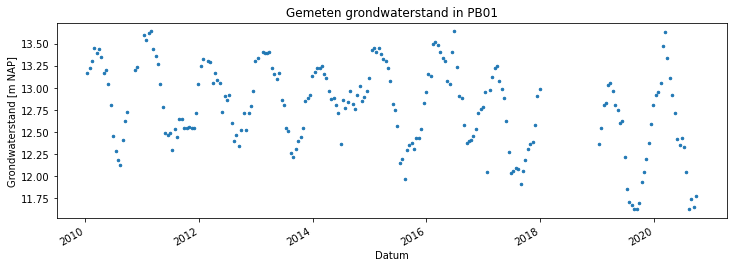

In [11]:
gws = pd.read_csv(r'data/PB05.csv', index_col=0, parse_dates=True)
gws_c = gws.copy()
gws = gws[~gws.index.year.isin([2018])]
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws['2010':].plot(ax=ax, color='C0', ls='', marker='.', markersize=5, legend=False)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in PB01');

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van de peilbuis. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. 

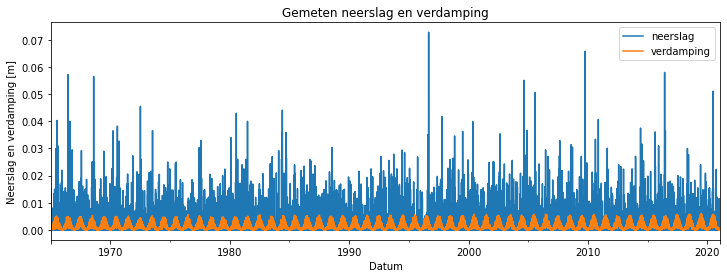

In [12]:
neerslag = pd.read_csv('data/neerslag.csv', index_col=0, parse_dates=True)
verdamping = pd.read_csv('data/verdamping.csv', index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend(['neerslag', 'verdamping']);

### Opzetten tijdreeksmodel

Er wordt een tijdreeksmodel opgesteld op basis van de meetreeks in PB05. Hiervoor worden de neerslag en verdamping gebruikt als verklarende reeksen. Voor de neerslag en verdamping wordt de Exponentiele respons functie gekozen voor de tijdreeksanalyse.


In [13]:
# opzetten model
ml = ps.Model(gws)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Exponential, name='gwa')
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve(report=False)

Het tijdreeksmodel heeft een R$^2$ van 0.92. De gesimuleerde grondwaterstand is te zien in de onderstaande afbeelding. Hierin is te zien dat het tijdreeksmodel de grondwaterstand goed simuleerd. Wel is hierbij te zien dat de data van 2018 ontbreekt. Het tijdreeksmodel simuleerd voor de zomer van 2018 een lage grondwaterstand zoals verwacht.

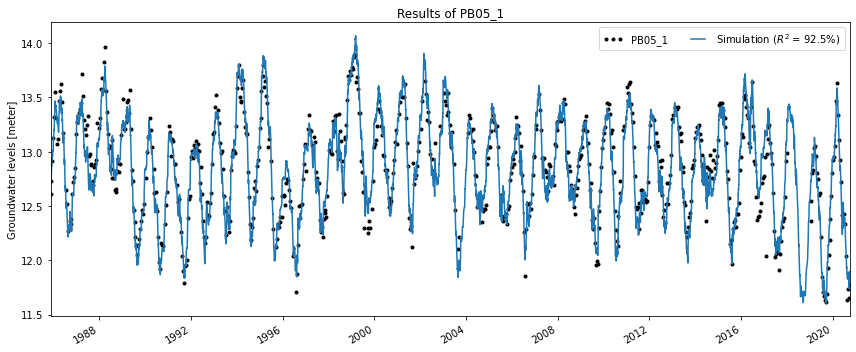

In [14]:
# plotten van de grondwaterstand
ml.plot(figsize=(12,5));

In de onderstaande tabel zijn de GXG waardes weergeven die zijn berekend met behulp van de gesimuleerde tijdreeks. Hierbij is het droge jaar 2018 meegenomen ook al zijn voor dit jaar geen metingen beschikbaar. 

Voor deze analyse moet worden opgemerkt dat de aanname is gemaakt dat het grondwatersysteem in het jaar 2018 hetzelfde reageert (de respons is gelijk) op de neerslag en verdamping als in andere jaren, ondanks de extreme droogte. Daarnaast is in deze analyse niet gekeken naar de onzekerheden van de berekende GXG. 

In [15]:
df = pd.DataFrame()
df.loc['tijdreeksmodel','GLG'] = ps.stats.glg(ml.simulate(tmin='2012'), min_n_years=8)
df.loc['tijdreeksmodel','GHG'] = ps.stats.ghg(ml.simulate(tmin='2012'), min_n_years=8)

display(df.round(2))

,GLG,GHG
tijdreeksmodel,12.16,13.38
